In [1]:
import os, warnings, sys
import pandas as pd
import pyarrow.parquet as pq
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
path = 'D:/Disco/Data/datasus'

sim = pq.ParquetDataset(f'{path}/SIM', use_legacy_dataset=False)
sinan = pq.ParquetDataset(f'{path}/SINAN', validate_schema=False)
sinasc = pq.ParquetDataset(f'{path}/SINASC', use_legacy_dataset=False)

#### Qual a média de idade das pessoas que faleceram por causa de acidentes de trabalho em cada região do Brasil?
- Quais as características das pessoas envolvidas nesses acidentes (sexo, escolaridade)?

In [4]:
data = pd.DataFrame()
columns = ['ACIDTRAB', 'SEXO', 'IDADE', 'CAUSABAS', 'ESC', 'OCUP', 'ASSISTMED', 'CIRURGIA', 'EXAME', 'LINHAA', 'CIRCOBITO', 'DTOBITO', 'DTNASC', 'RACACOR', 'LOCOCOR', 'CODMUNOCOR', 'STATE', 'YEAR']
for file in sim.files[:]:
    print(file)
    temp = pd.read_parquet(path=file)
    
    # alguns arquivos nao tem todas as colunas ou tem as colunas com nomes diferentes
    temp.rename(columns={'INSTRUCAO':'ESC', 'OCUPACAO':'OCUP', 'DATAOBITO':'DTOBITO', 'DATANASC':'DTNASC', 'MUNIOCOR':'CODMUNOCOR'}, inplace=True)
    #captura somente as colunas que estao na lista
    temp_columns = []
    for col in columns:
        if col in temp.columns and col not in temp_columns:
            temp_columns.append(col)
    
    #filtra somente os acidentes de trabalho
    temp = temp[temp_columns]
    temp = temp[temp['ACIDTRAB'] == '1']
    temp = temp.groupby(level=0, axis=1).first()

    if len(data)>0:
        data = data.groupby(level=0, axis=1).first()

    data = pd.concat([data,temp], ignore_index=True)

D:/Disco/Data/datasus/SIM/SIM_AC_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_AL_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_AM_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_AP_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_BA_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_CE_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_DF_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_ES_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_GO_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_MA_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_MG_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_MS_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_MT_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_PA_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_PB_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_PE_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_PI_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_PR_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_RJ_1994-2021.parquet
D:/Disco/Data/datasus/SIM/SIM_R

In [5]:
def decode_age(encoded_age):
    age = None
    encoded_age = str(encoded_age)
    if len(encoded_age) > 0:
        unit = encoded_age[0]
        quantity = int(encoded_age[1:])

        if unit == '1':
            age = quantity / (60 * 24 * 365)
        elif unit == '2':
            age = quantity / (24 * 365) 
        elif unit == '3':
            age = quantity / 12 
        elif unit == '4':
            age = quantity
        elif unit == '5':
            age = 100 
        else:
            age = None
    
    return age

def decode_esc(encoded_esc):
    esc = None
    encoded_esc = str(encoded_esc)
    if len(encoded_esc) > 0:
        unit = encoded_esc[0]

        if unit == '1':
            esc = 'Nenhuma'
        elif unit == '2':
            esc = '1 a 3 anos'
        elif unit == '3':
            esc = '4 a 7 anos'
        elif unit == '4':
            esc = '8 a 11 anos'
        elif unit == '5':
            esc = '12 anos ou mais'	
        else:
            esc = None
    
    return esc

def decode_sex(encoded_sex):
    esc = None
    encoded_sex = str(encoded_sex)
    if len(encoded_sex) > 0:
        unit = encoded_sex[0]

        if unit == '1':
            esc = 'Masculino'
        elif unit == '2':
            esc = 'Feminino'	
        else:
            esc = None
    
    return esc


def set_regiao(estado):
    regioes = {
        'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
        'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
        'Centro-Oeste': ['GO', 'MT', 'MS', 'DF'],
        'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
        'Sul': ['PR', 'RS', 'SC']
    }
    for regiao, estados in regioes.items():
        if estado in estados:
            return regiao
    return None


In [6]:
data['ACIDTRAB'] = pd.to_numeric(data['ACIDTRAB'], errors='coerce', downcast='integer')
data['SEXO'] = pd.to_numeric(data['SEXO'], errors='coerce', downcast='integer')
#data['IDADE'] = pd.to_numeric(data['IDADE'], errors='coerce', downcast='integer')
data['CAUSABAS'] = data['CAUSABAS'].astype('category')
data['ESC'] = pd.to_numeric(data['ESC'], errors='coerce', downcast='integer')
data['OCUP'] = data['OCUP'].astype('category')
data['ASSISTMED'] = pd.to_numeric(data['ASSISTMED'], errors='coerce', downcast='integer')
data['CIRURGIA'] = pd.to_numeric(data['CIRURGIA'], errors='coerce', downcast='integer')
data['EXAME'] = pd.to_numeric(data['EXAME'], errors='coerce', downcast='integer')
data['LINHAA'] = data['LINHAA'].astype('category')
data['CIRCOBITO'] = pd.to_numeric(data['CIRCOBITO'], errors='coerce', downcast='integer')
data['DTOBITO'] = pd.to_datetime(data['DTOBITO'], format='%d%m%Y', errors='coerce')
data['DTNASC'] = pd.to_datetime(data['DTNASC'], format='%d%m%Y', errors='coerce')


data['IDADED'] = data['IDADE'].apply(decode_age)
data['ESCD'] = data['ESC'].apply(decode_esc)
data = data[(data['SEXO'] == 1) | (data['SEXO'] == 2)]
data['SEXO'] = data['SEXO'].apply(decode_sex)

data['REGIAO'] = data['STATE'].apply(set_regiao)


In [7]:
print('Total de registros: ', len(data))

mean_age_by_region = data.groupby('STATE')['IDADED'].mean()

sex_counts = data['SEXO'].value_counts()
education_counts = data['ESCD'].value_counts()

print('Média de idade por estado:')
display(pd.DataFrame(mean_age_by_region))

print('\nDistribuição de sexo por estado:')
display(pd.DataFrame(sex_counts))
print('\nDistribuição de escolaridade por estado:')
display(pd.DataFrame(education_counts))

print('Média geral de idade: ', data['IDADED'].mean())

Total de registros:  83173
Média de idade por estado:


,IDADED
STATE,
AC,38.696697
AL,37.760090
AM,38.620527
AP,38.078283
BA,40.033892
CE,39.225286
DF,40.057661
ES,39.283902
GO,40.236516



Distribuição de sexo por estado:


,SEXO
Masculino,78942
Feminino,4231



Distribuição de escolaridade por estado:


,ESCD
4 a 7 anos,18639
8 a 11 anos,16496
1 a 3 anos,12519
12 anos ou mais,3743
Nenhuma,3411


Média geral de idade:  39.61564489061062


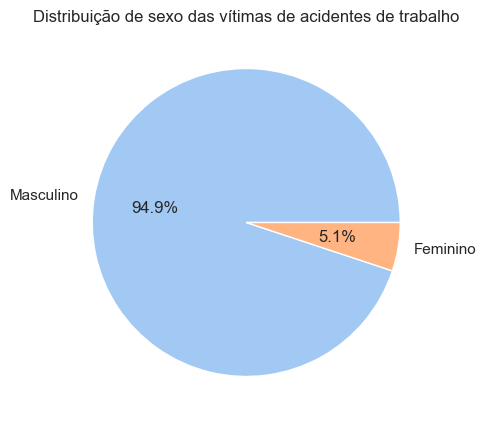

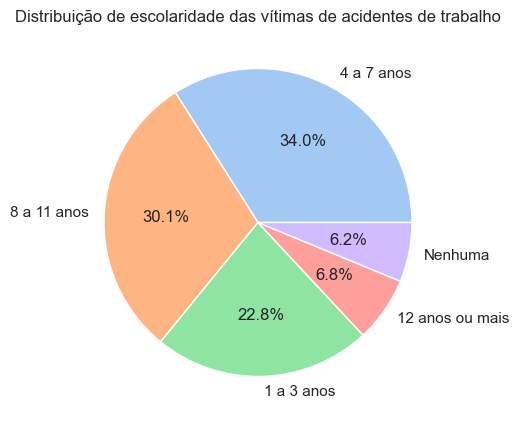

In [8]:

sns.set_theme(palette='pastel')

plt.figure(figsize=(5, 5))
plt.pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', colors=sns.color_palette())
plt.title('Distribuição de sexo das vítimas de acidentes de trabalho')
plt.show()

plt.figure(figsize=(5, 5))
plt.pie(education_counts.values, labels=education_counts.index, autopct='%1.1f%%', colors=sns.color_palette())
plt.title('Distribuição de escolaridade das vítimas de acidentes de trabalho')
plt.show()


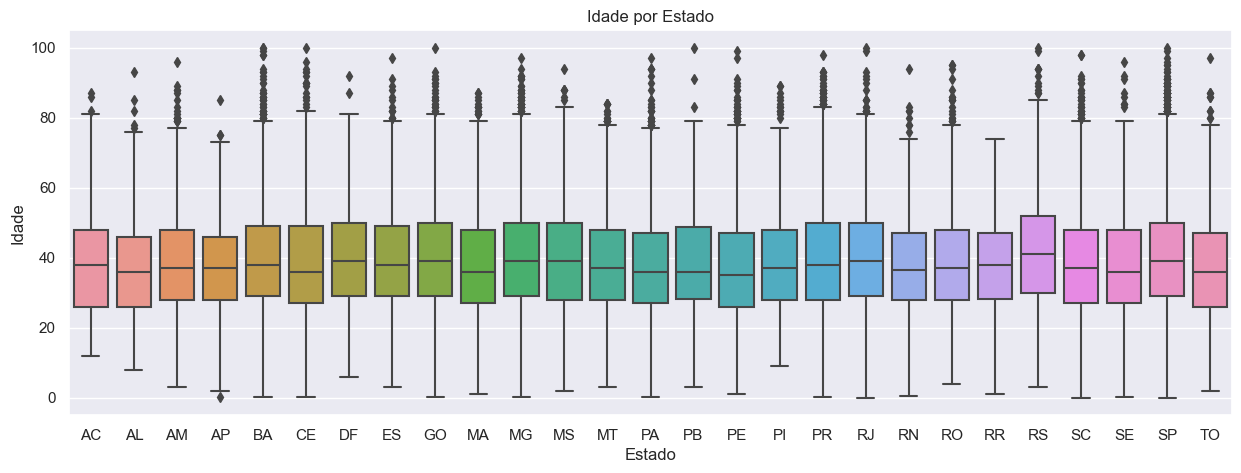

In [9]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='STATE', y='IDADED', data=data)

plt.title('Idade por Estado')
plt.xlabel('Estado')
plt.ylabel('Idade')
plt.show()

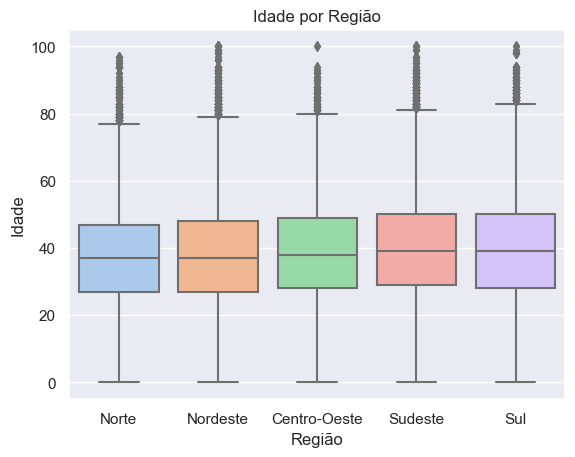

In [10]:
sns.boxplot(x='REGIAO', y='IDADED', data=data)

plt.title('Idade por Região')
plt.xlabel('Região')
plt.ylabel('Idade')
plt.show()
